# TPU ANN training script.

The input data is collected from simualting the experimental model.
Simulated model = 16 electrode system with an adjacent current injection and measurement pattern.

Input shape = 256
Output shape = 256 elements (sparse FEM)

In [0]:
input_data_name = '50k_16_c_pureElem_input_data.csv'
output_data_name = '50k_16_c_pureElem_output_data.csv'

data_path = '/content/gdrive/My Drive/Colab Notebooks/data/'
save_path = '/content/gdrive/My Drive/Colab Notebooks/Networks/ANN/'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import io
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
in_df = pd.read_csv(data_path+input_data_name, delimiter=',', prefix="Trial", skiprows=0, header=None)
out_df = pd.read_csv(data_path+output_data_name, delimiter=',', prefix="Trial", skiprows=0, header=None)



input_data = in_df.values
input_data = input_data[0:48000,:].astype('float32')
 
output_data = out_df.values
output_data = output_data[0:48000,:].astype('float32')

val_data = (in_df.values[48000:50000, :].astype('float32'), out_df.values[48000:50000, :].astype('float32'))

In [5]:
import os
import pprint # for pretty printing our device stats

if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

    with tf.Session(tpu_address) as session:
      devices = session.list_devices()

    print('TPU devices:')
    pprint.pprint(devices)

TPU address is grpc://10.37.3.194:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 8050314642953384110),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10932861222590220219),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12414226504418241184),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2065808580922944821),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2657613137137136128),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13829783192942760905),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 1696584534302685477),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 11368253464759051957),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1217410641709

In [0]:
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

In [8]:
with strategy.scope():
  
  model = tf.keras.models.Sequential()
  es = EarlyStopping(monitor='loss', mode = 'min', verbose = 1, patience = 60) 

  #Optimizers
  adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  sgd = tf.keras.optimizers.SGD(lr=0.02, momentum=0.01, decay=0.0, nesterov=True)
  
  # Architecture
  l0 = tf.keras.layers.Dense(units=256, activation='relu', input_dim=256)  
  l1 = tf.keras.layers.Dense(units=20, activation='tanh')
  l2 = tf.keras.layers.Dense(units=256, activation = 'linear')
  
  model = tf.keras.Sequential([l0, l1, l2])
  model.compile(loss='mean_squared_error', optimizer=adam)
  
  model.summary()

# 	# compiling the model using the RMSProp optimizer 
# 	# and Sparse Categorical Crossentropy loss
# 	model.compile(
# 		optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-2),
# 		loss=tf.keras.losses.sparse_categorical_crossentropy,
# 		metrics=['sparse_categorical_accuracy']
# 	)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               5376      
Total params: 76,308
Trainable params: 76,308
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_name = 'tpu_adam_256_20_256_16elec_ann_1'
t_start = time.time();

history = model.fit(input_data,  output_data, 
                    epochs=150, 
#                     steps_per_epoch=1150,
                    shuffle = True,
                    validation_data = val_data,
                    callbacks = [es],
                    verbose = 2)

t_elapsed = time.time() - t_start;

print("Completed Training in: %2.2fs" %(t_elapsed)) 
model.save(save_path+model_name+'.h5')

# save the history as well!
hist_df = pd.DataFrame(history.history) 

hist_csv_file = save_path+model_name+'_hist.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


Epoch 1/150
63/63 [==============================] - 1s 13ms/step
1500/1500 - 14s - loss: 0.1061 - val_loss: 0.0730
Epoch 2/150
63/63 [==============================] - 1s 14ms/step
1500/1500 - 13s - loss: 0.0730 - val_loss: 0.0729
Epoch 3/150
63/63 [==============================] - 1s 15ms/step
1500/1500 - 14s - loss: 0.0727 - val_loss: 0.0721
Epoch 4/150
63/63 [==============================] - 1s 16ms/step
1500/1500 - 14s - loss: 0.0717 - val_loss: 0.0706
Epoch 5/150
63/63 [==============================] - 1s 18ms/step
1500/1500 - 15s - loss: 0.0693 - val_loss: 0.0681
Epoch 6/150
63/63 [==============================] - 1s 20ms/step
1500/1500 - 15s - loss: 0.0665 - val_loss: 0.0652
Epoch 7/150
63/63 [==============================] - 1s 20ms/step
1500/1500 - 16s - loss: 0.0639 - val_loss: 0.0626
Epoch 8/150
63/63 [==============================] - 1s 22ms/step
1500/1500 - 16s - loss: 0.0613 - val_loss: 0.0614
Epoch 9/150
63/63 [==============================] - 1s 24ms/step
1500/1

In [0]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

## Load a previously saved model

In [0]:
# model = tf.keras.models.load_model(save_path+'tpu_adam_256_20_256_16elec_ann.h5')

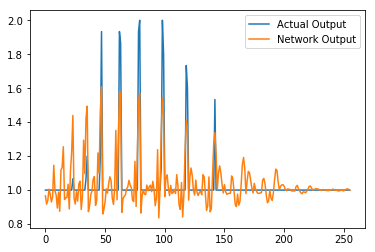

In [23]:
t = 845                #trial number
x = input_data[t,:]
o = output_data[t,:]

n = np.reshape(model.predict(np.array([x])), [256,])

plt.plot(o)
plt.plot(n)
plt.legend(['Actual Output', 'Network Output'], loc = 'upper right')